# DATA EXPLORATION

This notebook includes the different exploration done in the **data.csv** file.

In [1]:
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)

In [7]:
df = pd.read_csv("../data/data.csv")
df.head(1)

,date,article_id,company,lang,source,virality,all_esg_keywords,title+sentences,label
0,2019-06-27,29118d8af89ea0510f79757515c5868e28c742725be072...,CNEX Labs,english,deccanchronicle.com,5,['lawsuit'],Huawei loses trade secrets case versus US chip...,ESG


In [5]:
df.groupby(["article_id"]).agg({"label": "nunique"}).sort_values(by=["label"])

,label
article_id,
0000307829160b35be7b532bbd69613817976f76f3ccad2b591e9db2ba30ec4f,1
a3eadbabb134a27e75644d4423ba1bc4614c8580d57d78219cb4e4d1c2d02071,1
a3e3b29964c2589298c1ad281b7d4382c9b3b4b570c1180997ab017f8b1cd574,1
a3e1a07e68cb1c648528f23c3f3ccc52f7976790598d780c562edca876e049e1,1
a3ce42311946e1a80322dfb56b79e5e03c7cf9067de60eb069b65a04bdc5ba62,1
...,...
f8bb28db02904656cd7409ef6336feb0f8010684e1e06fa713565dcb3e5fbe00,2
b0fff7efda49411a49f3b00cdf9418ab262c67d27360f30041f4b62f583576c3,2
04e0724683bdf25155bb8588f5d2066c8499180ba8a394b0d75bfb91fa4ff5cb,2


**NOTE:** We ca remove articles that have more than one label since it does not help in the binary classification problem.

In [8]:
df.groupby(["article_id"]).agg({"title+sentences": "nunique"}).sort_values(by=["title+sentences"])

,title+sentences
article_id,
0000307829160b35be7b532bbd69613817976f76f3ccad2b591e9db2ba30ec4f,1
a4834f1662cd6e5518a182f708ae5c5fe61faddd3596a6b8df4be3ac308a1bef,1
a480abdae3ddd027ffc700af26bb3ea0aacdc048c74147d8216bc7122712ab1c,1
a47f27c21490e8fdc765535a257d07ec439c42cd77e62d5524a1921beb8f392e,1
a46f9672a05ca4f23ccbf57e072357abb810f11422b5f2f85324e878f03f47dc,1
...,...
4dc1e68741ce8c11ac443ca2a83e33676ef93f0bd5f777b6ddbe8ee9f5bc374c,1
4dc619744539cfd765074e9151562ae84ed3aa78e38632588e11f9b949b93162,1
4d895ab841095ea73ad749b78101d19c8c93243849cd52aea8086b9438e34778,1


In [10]:
df[df["article_id"] == "98298b4151c5c8c67b4ec37be5f285edc64f151fe6e3c6569f3df8ff1c19656f"]

,date,article_id,company,lang,source,virality,all_esg_keywords,title+sentences,label
1984,2019-12-01,98298b4151c5c8c67b4ec37be5f285edc64f151fe6e3c6...,Fiat Chrysler Automobiles N.V.,english,autocarpro.in,4,"['infringement', 'anti-competitive', 'litigati...",Mahindra and FCA continue sparring over design...,ESG
2168,2021-08-23,98298b4151c5c8c67b4ec37be5f285edc64f151fe6e3c6...,Fiat Chrysler Automobiles N.V.,english,autocarpro.in,3,"['infringement', 'litigation', 'anti-competiti...",Mahindra and FCA continue sparring over design...,ESG


In [17]:
a = df["title+sentences"].iloc[1984].split()
b = df["title+sentences"].iloc[2168].split()

In [41]:
l_idx = 0
r_idx = 217
a[l_idx:r_idx] == b[l_idx:r_idx]

True

**NOTE:** For the only *article_id* that has two different texts, we can keep only one text since both texts share the first 217 words (hypothesis: same remaining context in the text).

In [42]:
df.groupby(["lang", "label"]).agg({"article_id": "count"})

article_id
lang       label              
english    ESG            4883
           NOT ESG        3870
french     ESG             226
           NOT ESG         271
german     ESG              85
           NOT ESG          60
italian    ESG              52
           NOT ESG          34
japanese   ESG              75
           NOT ESG          73
portuguese ESG              94
           NOT ESG          73
spanish    ESG             124
           NOT ESG          80

**NOTE:** We observe that we have different languages, so we can use a multilungual pre-trained model from HuggingFace for the training step.

In [69]:
TAG_VALUES = ["ESG", "NOT ESG"]
TEXT_COLUMN = "title+sentences"
TARGET = "label"
ID = "article_id"
MAX_LENGTH = 512

tag2idx = {k: v for v, k in enumerate(sorted(TAG_VALUES))}
idx2tag = {v: k for v, k in enumerate(sorted(TAG_VALUES))}

def preprocessing(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()
    # Compute the number of words in the text column
    df["nb_words"] = df[TEXT_COLUMN].apply(lambda x: len(x.split()))
    # Compute number of labels for the same text
    df["nb_labels"] = df.groupby(ID)[TARGET].transform("nunique")
    # Keep rows that have only one label
    df = df[df["nb_labels"] == 1].reset_index()
    # Remove duplicates for the title+sentence
    df = df.drop_duplicates(subset=[ID]).reset_index()

    return df

In [49]:
new_df = preprocessing(df)

In [71]:
new_df.groupby(["lang", "label"]).agg({"article_id": "count"})

article_id
lang       label              
english    ESG            4399
           NOT ESG        3544
french     ESG             196
           NOT ESG         256
german     ESG              80
           NOT ESG          57
italian    ESG              51
           NOT ESG          32
japanese   ESG              74
           NOT ESG          70
portuguese ESG              88
           NOT ESG          68
spanish    ESG             123
           NOT ESG          80

In [50]:
df.shape
new_df.shape

(10000, 11)

(9118, 14)

In [54]:
import torch
from sklearn.model_selection import train_test_split

In [59]:
train_df, test_df = train_test_split(new_df, test_size=.2, random_state=17, stratify=new_df["lang"].values)
train_df, val_df = train_test_split(train_df, test_size=.2, random_state=17, stratify=train_df["lang"].values)

In [60]:
train_df.shape
val_df.shape
test_df.shape

(5835, 14)

(1459, 14)

(1824, 14)

In [61]:
train_df["lang"].value_counts()
val_df["lang"].value_counts()
test_df["lang"].value_counts()

lang
english       5083
french         289
spanish        130
portuguese     100
japanese        92
german          88
italian         53
Name: count, dtype: int64

lang
english       1271
french          73
spanish         32
portuguese      25
japanese        23
german          22
italian         13
Name: count, dtype: int64

lang
english       1589
french          90
spanish         41
portuguese      31
japanese        29
german          27
italian         17
Name: count, dtype: int64

In [67]:
class ESGDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer):
        texts = df[TEXT_COLUMN].tolist()
        labels = df[TARGET].tolist()
        self.tokenizer = tokenizer
        self.encodings = self.tokenizer(texts, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors="pt")
        self.labels = [tag2idx[label] for label in labels]

    # def get_batch_data(self, idx):
    #     return self.texts[idx]

    # def get_batch_label(self, idx):
    #     return torch.tensor(self.labels[idx])

    # def __getitem__(self, idx):
    #     batch_data = self.get_batch_data(idx)
    #     batch_labels = self.get_batch_label(idx)
    #     return batch_data, batch_labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.texts)

In [64]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

In [65]:
MODEL = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
tmp = tokenizer(df[TEXT_COLUMN].tolist(), padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors="pt")

In [73]:
tmp

{'input_ids': tensor([[  101, 87119, 61512,  ...,     0,     0,     0],
        [  101, 27746,   118,  ...,     0,     0,     0],
        [  101, 17909, 22872,  ...,     0,     0,     0],
        ...,
        [  101, 13888, 93413,  ...,     0,     0,     0],
        [  101, 62836, 13332,  ...,     0,     0,     0],
        [  101, 10818, 10171,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [74]:
train_dataset = ESGDataset(df=train_df, tokenizer=tokenizer)
val_dataset = ESGDataset(df=val_df, tokenizer=tokenizer)
test_dataset = ESGDataset(df=test_df, tokenizer=tokenizer)

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [77]:
test_dataset.labels

[0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,


In [ ]:

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end=True,
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

In [82]:
type(tokenizer)

transformers.models.bert.tokenization_bert_fast.BertTokenizerFast

In [3]:
df.shape

(10000, 9)

In [44]:
df[df["label"] == "NOT ESG"]

,date,article_id,company,lang,source,virality,all_esg_keywords,title+sentences,label,text_length,nb_labels
5,2022-10-15,112c31c7a179edbb228a4c26d71f2d2889fd44464f44b2...,Manchester United Plc,english,dispatchist.com,5,['assault'],Manchester United striker Mason Greenwood has ...,NOT ESG,17,1
19,2022-10-16,2ed8cebdabbaa6c0b6fc3ed31842f2a9699fad5170db2f...,Pilgrims Pride Corp,english,yahoo.com,5,['antitrust'],U.S. moves to dismiss price-fixing case agains...,NOT ESG,88,1
24,2020-01-23,49bcd0751e57bbbefbc9e8feb86d6f7d35cf1a2a51f239...,Spirit IP Cayman Ltd / Spirit Loyalty Cayman Ltd,english,bet.com,5,['investigation'],Spirit Airlines Passenger Says Man Slid His Ha...,NOT ESG,90,1
27,2020-01-24,9efb95fed6ff82066243a6f4727835ac9d4274c7137d20...,Peugeot S.A.,english,marketscreener.com,5,"['bribery', 'lawsuit', 'illegal']",General Motors : Fiat Chrysler denies union br...,NOT ESG,131,1
28,2020-01-24,a267d0625cc79fa05e39362c2bb4502eab79b64e0f4690...,Bethesda Softworks - full search,english,townandcountrytoday.com,5,"['strike', 'insult', 'disrespect']",Pentagon: 34 troops suffered brain injuries in...,NOT ESG,9,1
...,...,...,...,...,...,...,...,...,...,...,...
9990,2023-07-08,9fa41f4affcbf378e2f652e1f181be3ca7533f25148d36...,Activision Blizzard - full search,english,NaN,2,"['assault', 'strife', 'strike']",[Request] Rage Hack. oceanofrobbers is online ...,NOT ESG,795,1
9992,2023-07-08,a0508ad6d40a0b5b856581f0f72fb8750dfbf3d9c19275...,ZEIT ONLINE,german,NaN,2,['streit'],Zeit Online: «Streit ums Heizungsgesetz: SPD-M...,NOT ESG,167,1
9993,2023-07-08,a1793a6e8261c06da83893a2723b527b29814fc779292f...,BP PLC,english,NaN,2,['protest'],BP’s £30bn insurance policy; could a boardroom...,NOT ESG,93,1
9994,2023-07-08,a39cf289fad7a80418561a140375e327ac54ef8a26605f...,Alphabet Inc,english,NaN,2,['investigation'],"In Sargodha, 7 people were killed when a cylin...",NOT ESG,67,1


In [5]:
df.head()

,date,article_id,company,lang,source,virality,all_esg_keywords,title+sentences,label
0,2019-06-27,29118d8af89ea0510f79757515c5868e28c742725be072...,CNEX Labs,english,deccanchronicle.com,5,['lawsuit'],Huawei loses trade secrets case versus US chip...,ESG
1,2019-06-27,426cee1ad0d955e96a84fc793ee0c9421b9e1c1f09b176...,Steinhoff International Holdings N.V.,english,fin24.com,5,"['investigation', 'fraud', 'being investigated...",Ex-Tongaat official scrutinised in echo of Ste...,ESG
2,2019-06-27,65431893ef3358154068013868c5909e2418693807cbc2...,Enbridge Inc,english,yahoo.com,5,"['pollution', 'oil spill']",Wisconsin Supreme Court backs Enbridge in Dane...,ESG
3,2019-06-27,68199d1577983aea44b366364d346b361a0fd1ade9ee5c...,PG&E Corporation,english,ksby.com,5,['wildfire'],PG&E power line blamed for sparking Monterey C...,ESG
4,2022-10-14,d8d60aa50830599c92d87c0c6d056c5006109f6338a662...,TOTAL DIRECT ENERGIE ENTREPRISES,french,anygator.com,5,['conflit'],TotalEnergies visé par une plainte pour compli...,ESG


In [36]:
df["nb_labels"] = df.groupby("article_id")["label"].transform("nunique")

In [37]:
df["nb_labels"].value_counts()

nb_labels
1    9804
2     196
Name: count, dtype: int64

In [41]:
df["article_id"].iloc[9972]

'87df24afc45408c61d6618528d4e5862a72e5e0e877d4327bfaaa860bc22bdc8'

In [42]:
df[df["article_id"] == "87df24afc45408c61d6618528d4e5862a72e5e0e877d4327bfaaa860bc22bdc8"]

,date,article_id,company,lang,source,virality,all_esg_keywords,title+sentences,label,text_length,nb_labels
7437,2023-07-08,87df24afc45408c61d6618528d4e5862a72e5e0e877d43...,UBISOFT ENTERTAIN,english,NaN,3,"['investigation', 'prison', 'ddos attack']",Rainbow Six Siege cheater who swatted Ubisoft ...,ESG,264,2
9972,2023-07-08,87df24afc45408c61d6618528d4e5862a72e5e0e877d43...,Epic Games,english,NaN,2,"['investigation', 'prison', 'ddos attack']",Rainbow Six Siege cheater who swatted Ubisoft ...,NOT ESG,264,2


In [43]:
df["title+sentences"].iloc[7437]

'Rainbow Six Siege cheater who swatted Ubisoft Montreal with a fake hostage call gets a three-year community sentence. A Montreal Gazette report says 22-year-old Yanni “Y4nnOXX” Ouahioune, the man responsible for a 2020 swatting that forced the evacuation of Ubisoft Montreal, has been given a three-year community sentence—a non-custodial sentence that allows people convicted of some non-violent crimes to serve their time outside of prison—by a court in France. The incident occurred in November 2020, after a false report was made to police of a “hostage situation” at Ubisoft Montreal led to a major, day-long police operation. Ultimately, no hostages were found, and fortunately no one was injured; after it was determined that the call was false, Montreal Police said it would launch an investigation to “shed light on the call.” Suspicion eventually fell on Ouahioune, a French citizen and Rainbow Six Siege player who had been banned from the game multiple times for cheating and abusing dev

In [40]:
df[df["nb_labels"] == 2]["article_id"].iloc[9972]

IndexError: single positional indexer is out-of-bounds

In [33]:
df["text_length"] = df["title+sentences"].apply(lambda x: len(x.split()))

In [34]:
df["text_length"].describe()

count    10000.000000
mean       209.889800
std        171.055363
min          2.000000
25%         89.000000
50%        158.000000
75%        280.000000
max       1553.000000
Name: text_length, dtype: float64

In [6]:
df["lang"].value_counts()

lang
english       8753
french         497
spanish        204
portuguese     167
japanese       148
german         145
italian         86
Name: count, dtype: int64

In [7]:
df["article_id"].nunique()

9212

In [10]:
df.groupby(["article_id", "source"]).agg({"company": "count"}).sort_values(by="company")

,,company
article_id,source,
000393672764a630856394a593813af57b4689de02a0f58cd02a9f9bde8cc51a,ournet.in,1
9f1de1cbd23a17cd2416ba81d1f76e1621f1582d990ffe775a67e1226c1fbaa8,washingtonpost.com,1
9f2a360a4f8fc13233dd9dc1d5db0c8e7ca1089da9554879345818bdbe3ba72b,accountancydaily.co,1
9f6502c28c8589f1fb092b05c9f3bdd8e70b5667e055b5b29745c9d74506aa1c,boingboing.net,1
9f65d4b9ed51d325fccd87c833a7a46758e857ea60f95eab51107165e15bebfe,theinkwellonline.com,1
...,...,...
6b7ac168692b5d702c0ac07a8b1fb0f55801eac23bd4afc7c9959e1a21a667d8,thefashionlaw.com,3
ad50ad65e8b4026dab960f990b3ac09968bf7291335ecc81bc9e527e62ce7a52,marketscreener.com,4
8e9412a522580d9d41da2580041f401a2947b4c19632fb1c2b511436a208b497,econotimes.com,4


In [13]:
df.groupby(["article_id", "label"]).agg({"company": "count"}).sort_values(by="company")

,,company
article_id,label,
0000307829160b35be7b532bbd69613817976f76f3ccad2b591e9db2ba30ec4f,ESG,1
a1744b5ef8591f14bab2deaa3b68b37c965ef3260491253ffd83dd922917d30e,NOT ESG,1
a16fc45cee7ff6ad827279ee6f396937f61dd063938f21151d7931ba56fe0438,NOT ESG,1
a15549916be2f249241f6265b1d51ce4a50b2e6df113783373b7a4697d66d43d,NOT ESG,1
a1526f22bf0c53c669661d1323cff6a2d4b91a52ec6c34e9f62a9878c2c9b75b,NOT ESG,1
...,...,...
d7f3abab42b51aee268938d0364a8a34ad3d8b6e799ad92a90aa42a9043f16cd,NOT ESG,4
92f9233cf2634a75def189d0b082560e5dbcb6228d5c42a0603fd369614291fa,NOT ESG,4
8e9412a522580d9d41da2580041f401a2947b4c19632fb1c2b511436a208b497,ESG,4


In [29]:
label_df = df.groupby("article_id").agg({"label": "nunique", "virality": "nunique"}).sort_values(by=["label", "virality"])

In [20]:
label_df.shape
label_df[label_df["label"] == 2].shape

(9212, 1)

(94, 1)

In [28]:
label_df["virality"].value_counts()

virality
1    9103
2     109
Name: count, dtype: int64

In [30]:
label_df.tail()

,label,virality
article_id,,
a3c3425526badccaf53df46a62164089988ff22b561d9539747de6a355f7e962,2,2
d1c11807d8570f151687a12928cde294615e335696e0a6ced6132c3d1a74d012,2,2
e71089f02c8fb0b8dc0908721f7748a78e4fe94b0e03650f625a303458fbb49e,2,2
e8a020113d9bef6602ceac2468279973812286b67c127683dba8cdf5772837b7,2,2
e9079f82fcecc7e68eacb7cfbfacd6938cabf4bf1c4ce792164186dc39c724ec,2,2


In [31]:
df[df["article_id"] == "e9079f82fcecc7e68eacb7cfbfacd6938cabf4bf1c4ce792164186dc39c724ec"]

,date,article_id,company,lang,source,virality,all_esg_keywords,title+sentences,label
7118,2023-07-06,e9079f82fcecc7e68eacb7cfbfacd6938cabf4bf1c4ce7...,Thames Water (Kemble) Finance PLC,english,NaN,3,"['environmental impact', 'pollution']",Thames Water fined £3.33m after sewage leak ne...,ESG
9479,2023-07-06,e9079f82fcecc7e68eacb7cfbfacd6938cabf4bf1c4ce7...,Gatwick Airport Finance Plc,english,NaN,2,"['environmental impact', 'pollution']",Thames Water fined £3.33m after sewage leak ne...,NOT ESG


In [32]:
df["title+sentences"].iloc[7118]

'Thames Water fined £3.33m after sewage leak near Gatwick. Raw sewage pumped in rivers near Gatwick for around six hours, killing more than 1,400 fish in ‘reckless failure’ by Thames Water\nBy\nThames Water has been fined\n£3.33 million after ‘millions of litres’ of undiluted sewage was discharged into rivers near Gatwick Airport back in 2017 – the 21st fine that the company has faced for pollution spillage to date, bringing the total fines to the water firm to £35.7m between 2017 and 2023. After a two-day sentencing hearing at Lewes Crown Court, the court heard that a ‘significant and lengthy’ period of pollution occurred in the Gatwick Stream and River Mole between Crawley in West Sussex and Horley in Surrey, on 11 October 2017. Related articles\nInvestigators found almost ,1400 dead fish – including species such as chub, gudgeon, perch, pike and roach – in the Gatwick Stream and the River Mole, but the court heard this was only a small number of fish that the Environment Agency beli

In [81]:
from datasets import load_metric

In [16]:
df["title+sentences"].iloc[9102] == df["title+sentences"].iloc[9103]

True

In [17]:
df["title+sentences"].iloc[9102]

'Fortinet Bug: RUN — Don’t Walk — to Patch Critical RCE – Source: securityboulevard.com – CISO2CISO.COM & CYBER SECURITY GROUP. … In recent years, several Fortinet products have come under active exploitation. In February, hackers from multiple threat groups began exploiting a critical vulnerability in FortiNAC. … One researcher said that the targeting of the vulnerability, tracked as CVE-2022-39952 led to the “massive installation of webshells” that gave hackers remote access. … Last December, an unknown threat actor exploited a different critical vulnerability in the FortiOS SSL-VPN to infect government and government-related organizations with advanced custom-made malware.'

In [11]:
df[df["article_id"] == "5d320ed83f3ce20f0aacc3a5565ddd52c95efc7d50efb7ae97cb866ba8211fc2"]

,date,article_id,company,lang,source,virality,all_esg_keywords,title+sentences,label
4554,2020-02-18,5d320ed83f3ce20f0aacc3a5565ddd52c95efc7d50efb7...,Lg Chem Ltd ORD KRW5000,english,businesskorea.co.kr,1,"['infringement', 'lawsuit against', 'lawsuit',...",LG Chem Wins Battery Lawsuit against SK Innova...,ESG
4555,2020-02-18,5d320ed83f3ce20f0aacc3a5565ddd52c95efc7d50efb7...,"SK HOLDINGS CO., LTD.",english,businesskorea.co.kr,1,"['infringement', 'lawsuit against', 'lawsuit',...",LG Chem Wins Battery Lawsuit against SK Innova...,ESG
4556,2020-02-18,5d320ed83f3ce20f0aacc3a5565ddd52c95efc7d50efb7...,SK Inc,english,businesskorea.co.kr,1,"['infringement', 'lawsuit against', 'lawsuit',...",LG Chem Wins Battery Lawsuit against SK Innova...,ESG
4557,2020-02-18,5d320ed83f3ce20f0aacc3a5565ddd52c95efc7d50efb7...,SK On,english,businesskorea.co.kr,1,"['infringement', 'lawsuit against', 'lawsuit',...",LG Chem Wins Battery Lawsuit against SK Innova...,ESG
4558,2020-02-18,5d320ed83f3ce20f0aacc3a5565ddd52c95efc7d50efb7...,SK Innovation Co Ltd,english,businesskorea.co.kr,1,"['infringement', 'lawsuit against', 'lawsuit',...",LG Chem Wins Battery Lawsuit against SK Innova...,ESG


In [12]:
df["title+sentences"].iloc[4554]

'LG Chem Wins Battery Lawsuit against SK Innovation in U.S.. LG Chem has pulled off a victory in a lawsuit filed against SK Innovation regarding an infringement of its electric battery (EV) battery trade secrets. LG Chem and SK Innovation are expected to begin a settlement process in the near future. On Feb. 14 (local time), the U.S. International Trade Commission (ITC) made a default judgment against SK Innovation in a lawsuit between LG Chem and SK Innovation over a breach of rechargeable battery trade secrets. Following the preliminary decision, the ITC will make a final decision on Oct. 5 without holding additional hearings that were scheduled for early March. In April 2019, LG Chem filed a complaint against SK Innovation with the ITC and the Federal District Court of Delaware, the United States, claiming that the latter had taken out trade secrets about rechargeable batteries by hiring key personnel who worked at LG Chem. Later, in November of the same year, LG Chem requested a pr

In [8]:
df["virality"].value_counts()

virality
2    3131
3    2814
4    1761
5    1294
1    1000
Name: count, dtype: int64

In [83]:
history = [{'loss': 0.6809, 'learning_rate': 5e-06, 'epoch': 0.14, 'step': 50},
 {'eval_loss': 0.6668688058853149,
  'eval_precision': 0.6559287183002056,
  'eval_recall': 0.6559287183002056,
  'eval_f1': 0.6559287183002056,
  'eval_accuracy': 0.6559287183002056,
  'eval_runtime': 53.1716,
  'eval_samples_per_second': 27.439,
  'eval_steps_per_second': 0.433,
  'epoch': 0.14,
  'step': 50},
 {'loss': 0.5981, 'learning_rate': 1e-05, 'epoch': 0.27, 'step': 100},
 {'eval_loss': 0.5226926803588867,
  'eval_precision': 0.750514050719671,
  'eval_recall': 0.750514050719671,
  'eval_f1': 0.750514050719671,
  'eval_accuracy': 0.750514050719671,
  'eval_runtime': 52.5977,
  'eval_samples_per_second': 27.739,
  'eval_steps_per_second': 0.437,
  'epoch': 0.27,
  'step': 100},
 {'loss': 0.4821, 'learning_rate': 1.5e-05, 'epoch': 0.41, 'step': 150},
 {'eval_loss': 0.5589594841003418,
  'eval_precision': 0.7498286497601097,
  'eval_recall': 0.7498286497601097,
  'eval_f1': 0.7498286497601097,
  'eval_accuracy': 0.7498286497601097,
  'eval_runtime': 52.217,
  'eval_samples_per_second': 27.941,
  'eval_steps_per_second': 0.44,
  'epoch': 0.41,
  'step': 150},
 {'loss': 0.447, 'learning_rate': 2e-05, 'epoch': 0.55, 'step': 200},
 {'eval_loss': 0.40428152680397034,
  'eval_precision': 0.8156271418779987,
  'eval_recall': 0.8156271418779987,
  'eval_f1': 0.8156271418779987,
  'eval_accuracy': 0.8156271418779987,
  'eval_runtime': 53.2521,
  'eval_samples_per_second': 27.398,
  'eval_steps_per_second': 0.432,
  'epoch': 0.55,
  'step': 200},
 {'loss': 0.4233, 'learning_rate': 2.5e-05, 'epoch': 0.68, 'step': 250},
 {'eval_loss': 0.3845297396183014,
  'eval_precision': 0.8286497601096642,
  'eval_recall': 0.8286497601096642,
  'eval_f1': 0.8286497601096642,
  'eval_accuracy': 0.8286497601096642,
  'eval_runtime': 52.931,
  'eval_samples_per_second': 27.564,
  'eval_steps_per_second': 0.435,
  'epoch': 0.68,
  'step': 250},
 {'loss': 0.4101, 'learning_rate': 3e-05, 'epoch': 0.82, 'step': 300},
 {'eval_loss': 0.46490615606307983,
  'eval_precision': 0.7936943111720356,
  'eval_recall': 0.7936943111720356,
  'eval_f1': 0.7936943111720356,
  'eval_accuracy': 0.7936943111720356,
  'eval_runtime': 52.261,
  'eval_samples_per_second': 27.918,
  'eval_steps_per_second': 0.44,
  'epoch': 0.82,
  'step': 300},
 {'loss': 0.4445, 'learning_rate': 3.5e-05, 'epoch': 0.96, 'step': 350},
 {'eval_loss': 0.3855751156806946,
  'eval_precision': 0.8492117888965045,
  'eval_recall': 0.8492117888965045,
  'eval_f1': 0.8492117888965045,
  'eval_accuracy': 0.8492117888965045,
  'eval_runtime': 53.512,
  'eval_samples_per_second': 27.265,
  'eval_steps_per_second': 0.43,
  'epoch': 0.96,
  'step': 350},
 {'loss': 0.369, 'learning_rate': 4e-05, 'epoch': 1.1, 'step': 400},
 {'eval_loss': 0.38062942028045654,
  'eval_precision': 0.8361891706648389,
  'eval_recall': 0.8361891706648389,
  'eval_f1': 0.8361891706648389,
  'eval_accuracy': 0.8361891706648389,
  'eval_runtime': 53.1683,
  'eval_samples_per_second': 27.441,
  'eval_steps_per_second': 0.433,
  'epoch': 1.1,
  'step': 400},
 {'loss': 0.3885, 'learning_rate': 4.5e-05, 'epoch': 1.23, 'step': 450},
 {'eval_loss': 0.3921302258968353,
  'eval_precision': 0.8128855380397533,
  'eval_recall': 0.8128855380397533,
  'eval_f1': 0.8128855380397534,
  'eval_accuracy': 0.8128855380397533,
  'eval_runtime': 52.3572,
  'eval_samples_per_second': 27.866,
  'eval_steps_per_second': 0.439,
  'epoch': 1.23,
  'step': 450},
 {'loss': 0.3837, 'learning_rate': 5e-05, 'epoch': 1.37, 'step': 500},
 {'eval_loss': 0.6357724070549011,
  'eval_precision': 0.7991775188485264,
  'eval_recall': 0.7991775188485264,
  'eval_f1': 0.7991775188485264,
  'eval_accuracy': 0.7991775188485264,
  'eval_runtime': 53.5792,
  'eval_samples_per_second': 27.231,
  'eval_steps_per_second': 0.429,
  'epoch': 1.37,
  'step': 500},
 {'loss': 0.4579,
  'learning_rate': 4.579831932773109e-05,
  'epoch': 1.51,
  'step': 550},
 {'eval_loss': 0.4878237247467041,
  'eval_precision': 0.8087731322823852,
  'eval_recall': 0.8087731322823852,
  'eval_f1': 0.8087731322823852,
  'eval_accuracy': 0.8087731322823852,
  'eval_runtime': 52.9934,
  'eval_samples_per_second': 27.532,
  'eval_steps_per_second': 0.434,
  'epoch': 1.51,
  'step': 550},
 {'loss': 0.3887,
  'learning_rate': 4.159663865546219e-05,
  'epoch': 1.64,
  'step': 600},
 {'eval_loss': 0.43896275758743286,
  'eval_precision': 0.8190541466758053,
  'eval_recall': 0.8190541466758053,
  'eval_f1': 0.8190541466758053,
  'eval_accuracy': 0.8190541466758053,
  'eval_runtime': 52.4478,
  'eval_samples_per_second': 27.818,
  'eval_steps_per_second': 0.439,
  'epoch': 1.64,
  'step': 600},
 {'loss': 0.3561,
  'learning_rate': 3.739495798319328e-05,
  'epoch': 1.78,
  'step': 650},
 {'eval_loss': 0.4248490333557129,
  'eval_precision': 0.8245373543522961,
  'eval_recall': 0.8245373543522961,
  'eval_f1': 0.8245373543522961,
  'eval_accuracy': 0.8245373543522961,
  'eval_runtime': 53.2492,
  'eval_samples_per_second': 27.399,
  'eval_steps_per_second': 0.432,
  'epoch': 1.78,
  'step': 650},
 {'loss': 0.3742,
  'learning_rate': 3.319327731092437e-05,
  'epoch': 1.92,
  'step': 700},
 {'eval_loss': 0.37772688269615173,
  'eval_precision': 0.8355037697052776,
  'eval_recall': 0.8355037697052776,
  'eval_f1': 0.8355037697052776,
  'eval_accuracy': 0.8355037697052776,
  'eval_runtime': 52.9764,
  'eval_samples_per_second': 27.541,
  'eval_steps_per_second': 0.434,
  'epoch': 1.92,
  'step': 700},
 {'loss': 0.3874,
  'learning_rate': 2.8991596638655467e-05,
  'epoch': 2.05,
  'step': 750},
 {'eval_loss': 0.35517504811286926,
  'eval_precision': 0.8505825908156271,
  'eval_recall': 0.8505825908156271,
  'eval_f1': 0.8505825908156273,
  'eval_accuracy': 0.8505825908156271,
  'eval_runtime': 52.9522,
  'eval_samples_per_second': 27.553,
  'eval_steps_per_second': 0.434,
  'epoch': 2.05,
  'step': 750},
 {'loss': 0.2651,
  'learning_rate': 2.4789915966386556e-05,
  'epoch': 2.19,
  'step': 800},
 {'eval_loss': 0.40945878624916077,
  'eval_precision': 0.8430431802604523,
  'eval_recall': 0.8430431802604523,
  'eval_f1': 0.8430431802604524,
  'eval_accuracy': 0.8430431802604523,
  'eval_runtime': 53.4958,
  'eval_samples_per_second': 27.273,
  'eval_steps_per_second': 0.43,
  'epoch': 2.19,
  'step': 800},
 {'loss': 0.2047,
  'learning_rate': 2.058823529411765e-05,
  'epoch': 2.33,
  'step': 850},
 {'eval_loss': 0.40073156356811523,
  'eval_precision': 0.8560657984921178,
  'eval_recall': 0.8560657984921178,
  'eval_f1': 0.8560657984921178,
  'eval_accuracy': 0.8560657984921178,
  'eval_runtime': 52.8758,
  'eval_samples_per_second': 27.593,
  'eval_steps_per_second': 0.435,
  'epoch': 2.33,
  'step': 850},
 {'loss': 0.2031,
  'learning_rate': 1.638655462184874e-05,
  'epoch': 2.47,
  'step': 900},
 {'eval_loss': 0.5219679474830627,
  'eval_precision': 0.8478409869773817,
  'eval_recall': 0.8478409869773817,
  'eval_f1': 0.8478409869773817,
  'eval_accuracy': 0.8478409869773817,
  'eval_runtime': 52.4176,
  'eval_samples_per_second': 27.834,
  'eval_steps_per_second': 0.439,
  'epoch': 2.47,
  'step': 900},
 {'loss': 0.1912,
  'learning_rate': 1.2184873949579832e-05,
  'epoch': 2.6,
  'step': 950},
 {'eval_loss': 0.5086907744407654,
  'eval_precision': 0.8423577793008911,
  'eval_recall': 0.8423577793008911,
  'eval_f1': 0.8423577793008912,
  'eval_accuracy': 0.8423577793008911,
  'eval_runtime': 53.1988,
  'eval_samples_per_second': 27.425,
  'eval_steps_per_second': 0.432,
  'epoch': 2.6,
  'step': 950},
 {'loss': 0.2191,
  'learning_rate': 7.983193277310924e-06,
  'epoch': 2.74,
  'step': 1000},
 {'eval_loss': 0.4788510501384735,
  'eval_precision': 0.8498971898560658,
  'eval_recall': 0.8498971898560658,
  'eval_f1': 0.8498971898560657,
  'eval_accuracy': 0.8498971898560658,
  'eval_runtime': 52.903,
  'eval_samples_per_second': 27.579,
  'eval_steps_per_second': 0.435,
  'epoch': 2.74,
  'step': 1000},
 {'loss': 0.2152,
  'learning_rate': 3.7815126050420167e-06,
  'epoch': 2.88,
  'step': 1050},
 {'eval_loss': 0.42442238330841064,
  'eval_precision': 0.8608636052090473,
  'eval_recall': 0.8608636052090473,
  'eval_f1': 0.8608636052090473,
  'eval_accuracy': 0.8608636052090473,
  'eval_runtime': 52.5069,
  'eval_samples_per_second': 27.787,
  'eval_steps_per_second': 0.438,
  'epoch': 2.88,
  'step': 1050},
 {'train_runtime': 2767.2221,
  'train_samples_per_second': 6.326,
  'train_steps_per_second': 0.396,
  'total_flos': 4605759024076800.0,
  'train_loss': 0.3683847636392672,
  'epoch': 3.0,
  'step': 1095}]

In [102]:
eval_loss = [_.get("eval_loss") for _ in history if "eval_loss" in _]
loss = [_.get("loss") for _ in history if "loss" in _]
step = sorted(list(set([_.get("step") for _ in history if "step" in _]))[:-1])

In [103]:
len(eval_loss)
len(loss)
len(step)

21

21

21

In [104]:
step

[50,
 100,
 150,
 200,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 800,
 850,
 900,
 950,
 1000,
 1050,
 1095]

In [106]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot()

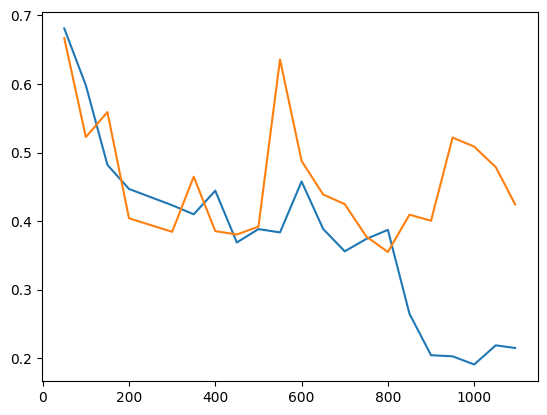

In [110]:
plt.plot(step, loss)
plt.plot(step, eval_loss)